# **Bacteria Prediction**

## **Data Loading**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Global variables
random_seed = 42

In [2]:
# Print directory structure
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-feb-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-feb-2022/train.csv
/kaggle/input/tabular-playground-series-feb-2022/test.csv


In [3]:
# Load training set
df = pd.read_csv("/kaggle/input/tabular-playground-series-feb-2022/train.csv")

## **Data Analysis**

In [4]:
df.shape

(200000, 288)

In [5]:
df.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
0,0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Streptococcus_pyogenes
1,1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Salmonella_enterica
2,2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,Salmonella_enterica
3,3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,Salmonella_enterica
4,4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Enterococcus_hirae


In [6]:
df.dtypes

row_id         int64
A0T0G0C10    float64
A0T0G1C9     float64
A0T0G2C8     float64
A0T0G3C7     float64
              ...   
A9T0G0C1     float64
A9T0G1C0     float64
A9T1G0C0     float64
A10T0G0C0    float64
target        object
Length: 288, dtype: object

In [7]:
# We drop the row_id column because we will not use it
df.drop(columns=["row_id"], inplace=True)
df.shape

(200000, 287)

In [8]:
# Check the presence of null values
df.isnull().values.any()

False

In [9]:
# Check that all the values in the dataframe are not equal to zero
df.all().all()

True

As we have seen, in the dataframe there aren't null or 0 values.

In [10]:
df.describe()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
count,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05
mean,6.421457e-07,-0.000003,-0.000014,-0.000010,0.000005,0.000025,0.000014,-0.000009,-0.000028,-0.000008,...,0.000135,0.000348,0.000253,0.000464,0.000581,0.000379,0.000062,8.982134e-05,1.170014e-04,2.215407e-07
std,8.654927e-05,0.000132,0.000287,0.000436,0.000683,0.000869,0.000775,0.000441,0.000107,0.000083,...,0.000711,0.001117,0.000914,0.001238,0.001528,0.001182,0.000466,5.475606e-04,6.788277e-04,2.050081e-05
min,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
25%,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
50%,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000237,-0.000199,-0.000114,-0.000043,-0.000010,...,0.000014,0.000064,0.000047,0.000124,0.000114,0.000043,-0.000010,4.632568e-07,4.632568e-07,-9.536743e-07
75%,-9.536743e-07,-0.000003,-0.000013,-0.000004,-0.000011,0.000003,-0.000030,0.000004,-0.000028,-0.000010,...,0.000111,0.000463,0.000297,0.000684,0.000774,0.000365,0.000030,6.046326e-05,6.946326e-05,-9.536743e-07
max,9.999046e-03,0.009990,0.009957,0.009886,0.019800,0.019760,0.019800,0.009886,0.009957,0.009990,...,0.019957,0.019914,0.019957,0.019914,0.019914,0.019957,0.009990,9.990463e-03,1.999046e-02,9.990463e-04


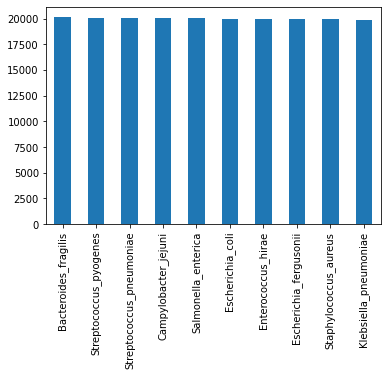

In [11]:
# Plot the distribution of values for the target column
df["target"].value_counts().plot(kind="bar");

As we can see, the different classes in the dataset are balanced.

## **Target Labels Encoding**

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
# Label encoding of the target.
# We will map each of the 10 different target classess to an intger in the range 0-9
label_encoder = LabelEncoder()
df["target"] = label_encoder.fit(df["target"]).transform(df["target"])
df.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,9
1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,6
2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,-0.000007,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,6
3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,-0.000007,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,6
4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,2


## **Train-Test Split**

In [14]:
# Imports
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(columns=["target"]), df["target"], test_size=0.33, stratify=df["target"], random_state=random_seed)

In [16]:
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (134000, 286)
Y_train shape: (134000,)
X_test shape: (66000, 286)
Y_test shape: (66000,)


In [17]:
# Further split the training set in training and validation sets
X_train_t, X_train_val, Y_train_t, Y_train_val = train_test_split(X_train, Y_train, test_size=0.20, stratify=Y_train, random_state=random_seed)

In [18]:
print(f"X_train_t shape: {X_train_t.shape}")
print(f"Y_train_t shape: {Y_train_t.shape}")
print(f"X_train_val shape: {X_train_val.shape}")
print(f"Y_train_val shape: {Y_train_val.shape}")

X_train_t shape: (107200, 286)
Y_train_t shape: (107200,)
X_train_val shape: (26800, 286)
Y_train_val shape: (26800,)


## **Dimensionality Reduction** 

### **Grid Search with Cross Validation to find the best value for n_components of PCA**

In [19]:
# Imports for PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Imports for PCA n_components tuning
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [20]:
st_scaler = StandardScaler()
pca = PCA()
classifier = DecisionTreeClassifier(criterion="entropy", random_state=random_seed)
pipe = Pipeline(steps=[("st_scaler", st_scaler), ("pca", pca), ("classifier", classifier)])

In [21]:
param_grid = {
    "pca__n_components": [3, 10, 20, 50]
}

In [22]:
grid_search = GridSearchCV(pipe, param_grid, cv=2, verbose=2)
grid_search.fit(X_train, Y_train);

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] pca__n_components=3 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. pca__n_components=3, total=   3.6s
[CV] pca__n_components=3 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s


[CV] .............................. pca__n_components=3, total=   3.5s
[CV] pca__n_components=10 ............................................
[CV] ............................. pca__n_components=10, total=   4.9s
[CV] pca__n_components=10 ............................................
[CV] ............................. pca__n_components=10, total=   4.8s
[CV] pca__n_components=20 ............................................
[CV] ............................. pca__n_components=20, total=   7.1s
[CV] pca__n_components=20 ............................................
[CV] ............................. pca__n_components=20, total=   7.2s
[CV] pca__n_components=50 ............................................
[CV] ............................. pca__n_components=50, total=  12.5s
[CV] pca__n_components=50 ............................................
[CV] ............................. pca__n_components=50, total=  12.5s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   56.1s finished


In [23]:
# Print grid search results
def print_grid_search_results(gscv):
    print("Best parameters set found on train set:")
    print(gscv.best_params_)
    print("\n")
    print("Grid scores on train set:")
    for param, mean, std in zip(gscv.cv_results_['params'], gscv.cv_results_['mean_test_score'], gscv.cv_results_['std_test_score']):
        print("%r mean: %0.3f std: +/- %0.03f)" % (param, mean, std))
    print("\n")

print_grid_search_results(grid_search)

Best parameters set found on train set:
{'pca__n_components': 10}


Grid scores on train set:
{'pca__n_components': 3} mean: 0.920 std: +/- 0.000)
{'pca__n_components': 10} mean: 0.923 std: +/- 0.002)
{'pca__n_components': 20} mean: 0.918 std: +/- 0.001)
{'pca__n_components': 50} mean: 0.910 std: +/- 0.000)




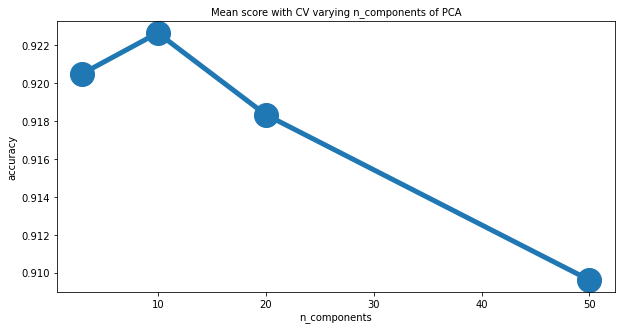

In [24]:
plt.figure(figsize=(10,5))
plt.plot(param_grid["pca__n_components"], grid_search.cv_results_['mean_test_score'], '-o', linewidth=5, markersize=24)
plt.xlabel('n_components')
plt.ylabel('accuracy')
plt.title("Mean score with CV varying n_components of PCA", fontsize = 10)
plt.show();

In [25]:
pca_components = grid_search.best_params_["pca__n_components"]

### **Compute PCA with the best hyper-parameter found**

In [26]:
# Standardize the features. This process is needed before doing the PCA.
st_scaler_t = StandardScaler()
st_scaler_t.fit(X_train_t)
X_train_t = st_scaler_t.transform(X_train_t)
X_train_val = st_scaler_t.transform(X_train_val)

print(f"Shape of X_train_t_st: {X_train_t.shape}")
print(f"Shape of X_train_val_st: {X_train_val.shape}")

Shape of X_train_t_st: (107200, 286)
Shape of X_train_val_st: (26800, 286)


In [27]:
# Perform PCA
pca_t = PCA(n_components=pca_components)
pca_t.fit(X_train_t)
X_train_t = pca_t.transform(X_train_t)
X_train_val = pca_t.transform(X_train_val)

print(f"Shape of X_train_t_pca: {X_train_t.shape}")
print(f"Shape of X_train_val_pca: {X_train_val.shape}")

Shape of X_train_t_pca: (107200, 10)
Shape of X_train_val_pca: (26800, 10)


In [28]:
# Transform also the full training set

# Standardize the features
st_scaler = StandardScaler()
st_scaler.fit(X_train)
X_train = st_scaler.transform(X_train)

# Perform PCA
pca = PCA(n_components=pca_components)
pca.fit(X_train)
X_train = pca.transform(X_train)

print(f"Shape of X_train_pca: {X_train.shape}")

Shape of X_train_pca: (134000, 10)


## **ML Models Testing**

In [29]:
from sklearn.metrics import classification_report

### **Decision Tree Classifier**

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [31]:
# Hyper-parameter tuning for max_depth of the decision tree
max_depth_list = [4,8,16,20,24,26]
scores = []

for par in max_depth_list:
    tree = DecisionTreeClassifier(criterion="entropy", random_state=random_seed, max_depth=par)
    tree.fit(X_train_t, Y_train_t)
    Y_predicted_val = tree.predict(X_train_val)
    score =  accuracy_score(Y_train_val, Y_predicted_val)
    scores.append(score)

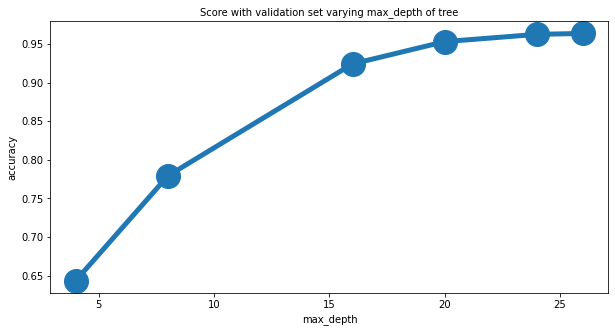

In [32]:
plt.figure(figsize=(10,5))
plt.plot(max_depth_list, scores, '-o', linewidth=5, markersize=24)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title("Score with validation set varying max_depth of tree", fontsize = 10)
plt.show();

In [33]:
# Test the tree model with the validation set using the best parameter found
best_max_depth = max_depth_list[np.argmax(scores)]
tree_model = DecisionTreeClassifier(criterion="entropy", random_state=random_seed, max_depth=best_max_depth)
tree_model.fit(X_train_t, Y_train_t)
Y_predicted = tree_model.predict(X_train_val)
print(classification_report(Y_train_val, Y_predicted, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

    Bacteroides_fragilis       0.97      0.98      0.98      2699
    Campylobacter_jejuni       0.98      0.98      0.98      2688
      Enterococcus_hirae       0.96      0.96      0.96      2673
        Escherichia_coli       0.94      0.95      0.95      2674
  Escherichia_fergusonii       0.96      0.96      0.96      2672
   Klebsiella_pneumoniae       0.98      0.99      0.99      2660
     Salmonella_enterica       0.96      0.95      0.96      2684
   Staphylococcus_aureus       0.98      0.97      0.97      2670
Streptococcus_pneumoniae       0.96      0.96      0.96      2690
  Streptococcus_pyogenes       0.94      0.95      0.95      2690

                accuracy                           0.96     26800
               macro avg       0.96      0.96      0.96     26800
            weighted avg       0.96      0.96      0.96     26800



In [34]:
# Define the final model with the best parameter found
best_max_depth = max_depth_list[np.argmax(scores)]
tree_model = DecisionTreeClassifier(criterion="entropy", random_state=random_seed, max_depth=best_max_depth)

## **Random Forest**

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
# Hyper-parameter tuning for n_estimators of the random forest
n_estimators_list = [5,10,20,50,100,150]
scores = []

for par in n_estimators_list:
    forest = RandomForestClassifier(criterion="entropy", n_estimators=par, random_state=random_seed)
    forest.fit(X_train_t, Y_train_t)
    Y_predicted_val = forest.predict(X_train_val)
    score =  accuracy_score(Y_train_val, Y_predicted_val)
    scores.append(score)

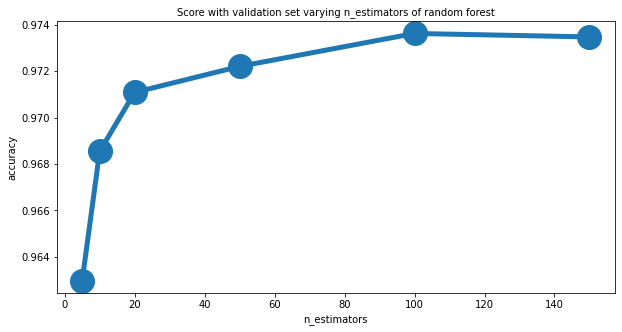

In [37]:
plt.figure(figsize=(10,5))
plt.plot(n_estimators_list, scores, '-o', linewidth=5, markersize=24)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.title("Score with validation set varying n_estimators of random forest", fontsize = 10)
plt.show();

In [38]:
# Test the tree model with the validation set using the best parameter found
best_n_estimators = n_estimators_list[np.argmax(scores)]
rnd_forest_model = RandomForestClassifier(criterion="entropy", n_estimators=best_n_estimators, random_state=random_seed)
rnd_forest_model.fit(X_train_t, Y_train_t)
Y_predicted = rnd_forest_model.predict(X_train_val)
print(classification_report(Y_train_val, Y_predicted, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

    Bacteroides_fragilis       0.98      0.99      0.98      2699
    Campylobacter_jejuni       0.98      0.99      0.98      2688
      Enterococcus_hirae       0.97      0.97      0.97      2673
        Escherichia_coli       0.96      0.96      0.96      2674
  Escherichia_fergusonii       0.97      0.97      0.97      2672
   Klebsiella_pneumoniae       0.99      0.99      0.99      2660
     Salmonella_enterica       0.97      0.97      0.97      2684
   Staphylococcus_aureus       0.98      0.98      0.98      2670
Streptococcus_pneumoniae       0.97      0.97      0.97      2690
  Streptococcus_pyogenes       0.96      0.96      0.96      2690

                accuracy                           0.97     26800
               macro avg       0.97      0.97      0.97     26800
            weighted avg       0.97      0.97      0.97     26800



In [39]:
# Define the final model with the best parameter found
best_n_estimators = n_estimators_list[np.argmax(scores)]
rnd_forest_model = RandomForestClassifier(criterion="entropy", n_estimators=best_n_estimators, random_state=random_seed)

### **Extremely Randomized Trees**

In [40]:
from sklearn.ensemble import ExtraTreesClassifier

In [41]:
# Hyper-parameter tuning for n_estimators of the extremely randomized trees
n_estimators_list = [5,10,20,50,100,150]
scores = []

for par in n_estimators_list:
    forest = ExtraTreesClassifier(criterion="entropy", n_estimators=par, random_state=random_seed)
    forest.fit(X_train_t, Y_train_t)
    Y_predicted_val = forest.predict(X_train_val)
    score =  accuracy_score(Y_train_val, Y_predicted_val)
    scores.append(score)

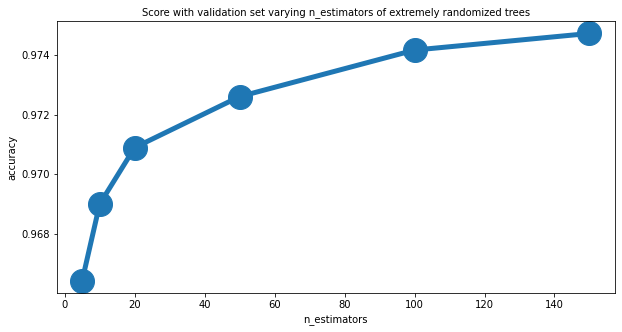

In [42]:
plt.figure(figsize=(10,5))
plt.plot(n_estimators_list, scores, '-o', linewidth=5, markersize=24)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.title("Score with validation set varying n_estimators of extremely randomized trees", fontsize = 10)
plt.show();

In [43]:
# Test the model with the validation set using the best parameter found
best_n_estimators = n_estimators_list[np.argmax(scores)]
ext_rnd_trees_model = ExtraTreesClassifier(criterion="entropy", n_estimators=best_n_estimators, random_state=random_seed)
ext_rnd_trees_model.fit(X_train_t, Y_train_t)
Y_predicted = ext_rnd_trees_model.predict(X_train_val)
print(classification_report(Y_train_val, Y_predicted, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

    Bacteroides_fragilis       0.98      0.99      0.99      2699
    Campylobacter_jejuni       0.98      0.99      0.99      2688
      Enterococcus_hirae       0.97      0.97      0.97      2673
        Escherichia_coli       0.96      0.96      0.96      2674
  Escherichia_fergusonii       0.97      0.96      0.97      2672
   Klebsiella_pneumoniae       0.99      0.99      0.99      2660
     Salmonella_enterica       0.97      0.97      0.97      2684
   Staphylococcus_aureus       0.98      0.98      0.98      2670
Streptococcus_pneumoniae       0.97      0.97      0.97      2690
  Streptococcus_pyogenes       0.97      0.96      0.97      2690

                accuracy                           0.97     26800
               macro avg       0.97      0.97      0.97     26800
            weighted avg       0.97      0.97      0.97     26800



In [44]:
# Define the final model with the best parameter found
best_n_estimators = n_estimators_list[np.argmax(scores)]
ext_rnd_trees_model = ExtraTreesClassifier(criterion="entropy", n_estimators=best_n_estimators, random_state=random_seed)

### **Deep Neural Network**

In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [46]:
# Network architecture definition
inputs = keras.Input(shape=(pca_components,))
x = layers.Dense(30, activation="relu")(inputs)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dense(50, activation="relu")(x)
x = layers.Dense(30, activation="relu")(x)
x = layers.Dense(20, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)

dnn_model = keras.Model(inputs=inputs, outputs=outputs, name="dnn_model")
dnn_model.summary()

Model: "dnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 30)                330       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_4 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                21

2022-03-09 09:03:05.571500: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [47]:
dnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [48]:
history = dnn_model.fit(X_train_t, Y_train_t, batch_size=64, epochs=5, validation_data=(X_train_val, Y_train_val))

2022-03-09 09:03:06.125601: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
1675/1675 [==============================] - 8s 4ms/step - loss: 0.7184 - accuracy: 0.7380 - val_loss: 0.4990 - val_accuracy: 0.8204
Epoch 2/5
1675/1675 [==============================] - 7s 4ms/step - loss: 0.4633 - accuracy: 0.8224 - val_loss: 0.4212 - val_accuracy: 0.8381
Epoch 3/5
1675/1675 [==============================] - 7s 4ms/step - loss: 0.4149 - accuracy: 0.8345 - val_loss: 0.3975 - val_accuracy: 0.8432
Epoch 4/5
1675/1675 [==============================] - 6s 4ms/step - loss: 0.3909 - accuracy: 0.8404 - val_loss: 0.3765 - val_accuracy: 0.8496
Epoch 5/5
1675/1675 [==============================] - 7s 4ms/step - loss: 0.3751 - accuracy: 0.8460 - val_loss: 0.3644 - val_accuracy: 0.8538


## **Final Model Evaluation**

In [49]:
from sklearn.metrics import classification_report

In [50]:
final_model = rnd_forest_model
use_neural_network = False

In [51]:
# Preprocess the data

# Standardize
X_test = st_scaler.transform(X_test)
# PCA
X_test = pca.transform(X_test)

In [52]:
if use_neural_network:
    # Predict probabilty distributions over possible labels
    Y_test_pred_p = final_model.predict(X_test)
    # Store the index of the most probable label
    Y_test_pred = np.argmax(Y_test_pred_p, axis=1)
else:
    # Train the model on the full training set
    final_model.fit(X_train, Y_train)
    # Directly predict labels
    Y_test_pred = final_model.predict(X_test)

In [53]:
print(classification_report(Y_test, Y_test_pred, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

    Bacteroides_fragilis       0.99      0.99      0.99      6646
    Campylobacter_jejuni       0.99      0.99      0.99      6621
      Enterococcus_hirae       0.98      0.98      0.98      6583
        Escherichia_coli       0.97      0.97      0.97      6586
  Escherichia_fergusonii       0.97      0.98      0.97      6579
   Klebsiella_pneumoniae       1.00      0.99      0.99      6549
     Salmonella_enterica       0.98      0.98      0.98      6610
   Staphylococcus_aureus       0.99      0.99      0.99      6577
Streptococcus_pneumoniae       0.98      0.97      0.98      6624
  Streptococcus_pyogenes       0.98      0.97      0.98      6625

                accuracy                           0.98     66000
               macro avg       0.98      0.98      0.98     66000
            weighted avg       0.98      0.98      0.98     66000



## **Kaggle Submission Test**

In [54]:
# Load Kaggle's submission test set
df_subm = pd.read_csv("/kaggle/input/tabular-playground-series-feb-2022/test.csv")
df_subm.head()

,row_id,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
0,200000,-9.536743e-07,-0.000002,-9.153442e-07,0.000024,0.000034,-0.000002,0.000021,0.000024,-0.000009,...,0.000039,0.000085,0.000055,0.000108,0.000090,0.000059,0.000010,0.000006,0.000027,4.632568e-08
1,200001,-9.536743e-07,-0.000010,-4.291534e-05,-0.000114,0.001800,-0.000240,0.001800,-0.000114,0.000957,...,-0.000043,0.000914,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07
2,200002,4.632568e-08,0.000003,8.465576e-08,-0.000014,0.000007,-0.000005,-0.000004,0.000003,0.000004,...,0.000041,0.000102,0.000084,0.000111,0.000117,0.000070,0.000020,0.000030,0.000021,4.632568e-08
3,200003,-9.536743e-07,-0.000008,8.084656e-06,0.000216,0.000420,0.000514,0.000452,0.000187,-0.000005,...,0.000069,0.000158,0.000098,0.000175,0.000217,0.000150,0.000018,0.000016,0.000051,-9.536743e-07
4,200004,-9.536743e-07,-0.000010,-4.291534e-05,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,...,-0.000043,-0.000086,-0.000043,-0.000086,0.000914,-0.000043,-0.000010,-0.000010,0.000990,-9.536743e-07


In [55]:
df_subm_results = pd.DataFrame(df_subm["row_id"])
df_subm_results.head()

,row_id
0,200000
1,200001
2,200002
3,200003
4,200004


In [56]:
X_subm = df_subm.drop(columns="row_id")

In [57]:
# Standardize test set
X_subm = st_scaler.transform(X_subm)
X_subm.shape

# PCA transform on test set
X_subm = pca.transform(X_subm)
X_subm.shape

(100000, 10)

In [58]:
if use_neural_network:
    # Predict probabilty distributions over possible labels
    Y_subm_predicted_p = final_model.predict(X_subm)
    # Store the index of the most probable label
    Y_subm_predicted = np.argmax(Y_subm_predicted_p, axis=1)
else:
    Y_subm_predicted = final_model.predict(X_subm)

# Convert label indexes to text
Y_subm_predicted_labeled = label_encoder.inverse_transform(Y_subm_predicted)
# Store the predicted targets in the dataframe
df_subm_results["target"] = Y_subm_predicted_labeled

In [59]:
df_subm_results.head()

,row_id,target
0,200000,Escherichia_fergusonii
1,200001,Salmonella_enterica
2,200002,Enterococcus_hirae
3,200003,Salmonella_enterica
4,200004,Staphylococcus_aureus


In [60]:
df_subm_results.to_csv("submission.csv", index=False)